# Predicting whether a cheese is higher fat or not
#### A final project by Young Ji Tuen

## Introduction
In this project, I aim to answer the question: **is this cheese higher or lower fat?** Using data on different types of Canadian cheeses, I hope to train a model to help **classify** a given cheese into the 'higher fat' or 'lower fat' classes. For this classification problem, **higher fat** is the positive label. 

In [1]:
import string
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, SVR
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score,make_scorer
from altair import *

## Exploratory data analysis

In [2]:
cheese_df = pd.read_csv("data/cheese_data.csv")
print(cheese_df.shape)

(1042, 13)


There are 1042 different types of cheese and 13 columns! After reading in the cheese data, let's split the data into a train and test set using a 80/20 train to test split.

In [3]:
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=123)

I want to take a look at a summary of the train data.

In [4]:
cheese_described = train_df.describe()
cheese_described

,CheeseId,MoisturePercent,Organic
count,833.000000,821.000000,833.000000
mean,1563.432173,47.052741,0.091236
std,445.350681,9.660351,0.288118
min,228.000000,12.000000,0.000000
25%,1290.000000,40.000000,0.000000
50%,1554.000000,46.000000,0.000000
75%,1897.000000,52.000000,0.000000
max,2391.000000,92.000000,1.000000


Even though there are many more columns in the dataframe, .describe() only summarized 3. This is because all the other columns contain non-numerical data. We will need to transform them into numerical values later. 

Let's see if there are any null values in the dataset.

In [5]:
cheese_info = train_df.info()
cheese_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 482 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       821 non-null    float64
 4   FlavourEn             637 non-null    object 
 5   CharacteristicsEn     522 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        813 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   781 non-null    object 
 10  RindTypeEn            579 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


It seems that MoisturePercent, FlavourEn, CharacteristicsEn, CategoryTypeEn, MilkTypeEn, MilkTreatmentTypeEn, and RindTypeEn all have null values. SimpleImputer will be used to remove any null values.

Since FatLevel is our target, let's create a bar graph to show the quantity of each fat level in the training data. 

In [6]:
fig_1 = alt.Chart(train_df, width=300, height=300).mark_bar().encode(
        x = alt.X("FatLevel", title="Fat Level"),
        y = alt.Y("count()", title="Quantity")).properties(
            title="Figure 1. Quantity of the different fat levels")

fig_1

alt.Chart(...)

It seems that the distribution of higher and lower fat cheeses in the training data is **imbalanced**; there are almost twice as many cheeses in the lower fat class than in the higher fat class. To handle this imbalance, we can use the class_weight argument in our estimator later. 

Let's see how much cheese the different Canadian provinces produce, and whether they have a preference for one fat level. 

In [7]:
fig_2 = alt.Chart(train_df, width=50, height=300).mark_bar().encode(
    column = Column("ManufacturerProvCode"),       
    x = alt.X("FatLevel", axis=None),
    y = alt.Y("count()", title="Quantity"),
    color = "FatLevel").configure_view(
        stroke=None,).properties(
        title = "Figure 2. Fat levels by Canadian Province")

fig_2

alt.Chart(...)

It looks like Quebec is a big cheese manufacturer! Most provinces are producing a greater proportion of lower fat cheeses. 

## Methods and Results

Now let's think about which columns we need. We will drop FlavourEn, CharacteristicsEn, and CheeseName to avoid having to use CountVectorizer. CheeseId will also not be included as it is not relevant for predicting FatLevel. 

This means our feature table will only include: 
- ManufacturerProvCode (categorical)
- ManufacturingTypeEn (categorical)
- MoisturePercent (numeric)
- Organic (binary)
- CategoryTypeEn (categorical)
- MilkTypeEn (categorical)
- MilkTreatmentTypeEn (categorical)

Let's split cheese_train and cheese_test into the relevant feature and target objects. Here, our target is **FatLevel**.

In [8]:
X_train = train_df.drop(columns=["CheeseId", "FlavourEn", "CharacteristicsEn", "CheeseName", "FatLevel"])
y_train = train_df["FatLevel"]
X_test = test_df.drop(columns=["CheeseId", "FlavourEn", "CharacteristicsEn", "CheeseName", "FatLevel"])
y_test = test_df["FatLevel"] 

# take a look at 5 rows of the X_train set 
X_train.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn
482,QC,Artisan,48.0,0,Semi-soft Cheese,Cow,Pasteurized,Washed Rind
896,QC,Artisan,45.0,0,Veined Cheeses,Cow,Pasteurized,NaN
421,QC,Industrial,50.0,0,Soft Cheese,Cow,Pasteurized,Bloomy Rind
929,BC,Artisan,40.0,0,Semi-soft Cheese,Cow,Pasteurized,No Rind
737,QC,Artisan,65.0,0,Fresh Cheese,Cow,Pasteurized,No Rind


We will need a dummy classifier to compare our estimators to. 

In [9]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

# cross validate the dummy model, returning train scores
dummy_scores = pd.DataFrame(cross_validate(dummy_model, X_train, y_train, cv=5, 
    return_train_score=True))

# calculate the mean scores 
mean_dummy_scores = dummy_scores.mean()
print(mean_dummy_scores)

fit_time       0.001467
score_time     0.000717
test_score     0.657860
train_score    0.657863
dtype: float64


Now it is time to build a column transformer to transform the data. Missing values will be removed by SimpleImputer. Categorical variables will be represented by binary columns using OneHotEncoder. Binary features will be handled with OneHotEncoder such that the redundant column will be dropped. Numeric values will be standardized using StandardScaler. We do not have ordinal or text data. 

In [10]:
# group the relevant features into categorical, binary, and numeric 
categorical_features = ["ManufacturerProvCode", "ManufacturingTypeEn", "CategoryTypeEn", "MilkTypeEn", "MilkTreatmentTypeEn"]
binary_features = ["Organic"]
numeric_features = ["MoisturePercent"]

# create transformers for each type of feature 
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                        OneHotEncoder(handle_unknown="ignore"))
binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                   OneHotEncoder(handle_unknown="error", drop="if_binary"))
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), 
                                    StandardScaler())

# create a column transformer combining the above transformer pipelines
preprocessor = make_column_transformer(
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features),
    (numeric_transformer, numeric_features)
)

In order to find the best model to answer the question of which fat level a cheese has, we should find the best gamma and C. We can tune these two hyperparameters simultaneously. Here, I'd like to look at every possible combination of hyperparameters to find the best model. Thus, I've chosen to use  **GridSearchCV** to conduct hyperparameter optimization. In contrast, RandomizedSearchCV does not conduct an exhaustive search and randomly searches from a grid of hyperparameters. 

In [11]:
# define the hyperparameters to be tuned
hyperparameters = {
    "SVC__gamma": [0.1, 1.0, 10.0, 100.0],
    "SVC__C": [0.1, 1.0, 10.0, 100.0]
}

When we are building our main pipeline with the estimator, we should enter class_weight="balanced" since our target feature is imbalanced. We want to give equal weight to the positive 'higher fat' and negative 'lower fat' classes. 

In [12]:
main_pipe = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("SVC", SVC(random_state=123, class_weight="balanced"))
    ]
)

We should also choose an appropriate metric for scoring this classification model. Since there is a class imbalance, accuracy may be a misleading metric. Using precision or recall alone may be insufficient in describing the model's performance. The model's f1 score combines precision and recall to give a single score, and will be used to score the SVC estimator. 

In [13]:
# make a custom scorer and define the positive label as 'higher fat'
f1_scorer = make_scorer(f1_score, pos_label="higher fat")

# build an automated hyperparameter optimizer using GridSearchCV
grid_search = GridSearchCV(main_pipe, hyperparameters, cv=5, return_train_score=True,
                           verbose=1, n_jobs=-1, scoring=f1_scorer)

# fit the train data onto grid_search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ManufacturerProvCode',
                                                                          'ManufacturingTypeEn',
                                                                          'CategoryTypeEn',
                                                                        

Let's save and print the best parameters and f1 score of our estimator.

In [14]:
best_parameters = grid_search.best_params_
print(best_parameters)

best_score = grid_search.best_score_
print(best_score)

{'SVC__C': 10.0, 'SVC__gamma': 0.1}
0.746512922497295


What are the train and test scores of the best scoring model?

In [15]:
train_score = grid_search.score(X_train, y_train)
print("The train score is ", train_score)

test_score = grid_search.score(X_test, y_test)
print("The test score is ", test_score)

The train score is  0.8018867924528302
The test score is  0.7218934911242603


To visualize the performance of the model, let's plot a confusion matrix.

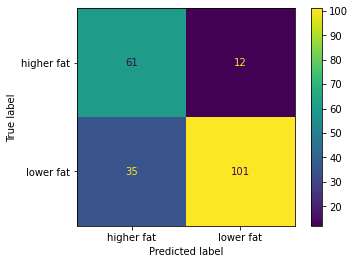

In [16]:
print(plot_confusion_matrix(grid_search, X_test, y_test))

I want to assess the model's X_test predictions further through a classification report. 

In [17]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

  higher fat       0.64      0.84      0.72        73
   lower fat       0.89      0.74      0.81       136

    accuracy                           0.78       209
   macro avg       0.76      0.79      0.77       209
weighted avg       0.80      0.78      0.78       209



## Discussion

The train score of my model is 0.80, the test score is 0.72 and the weighted average of the f1-score is 0.78. In comparison, my baseline model scored 0.66. 

Of the cheeses my model predicted as higher fat, 64% (61/96) of them were truly higher fat. Of those predicted as lower fat, 89% (101/113) were truly lower fat. Overall, the weighted average precision score was 0.80. 

Among all the true higher fat cheeses, my model was able to identify 84% (61/73) of them, and among all the true lower fat cheeses, it was able to identify 74% (101/136) of them. 

To conclude, my model performed better than the dummy model in classifying a cheese into either the 'higher fat' or 'lower fat' classes based on their other characteristics. For the purposes of this project, I did not analyze the flavour descriptions of each cheese. Higher fat cheeses may be more likely to be described as 'creamy' or 'buttery' than lower fat cheeses, which may be more 'mild' and 'light'. It is possible that if I had transformed and included the FlavourEn feature in my model, it would have performed better. 

## References

- Guidance for this project was obtained from Modules 1-8 of UBC's Extended Learning Course FS031S23O Introduction to Machine Learning
- jakevdp (2020), GitHub Repository, https://github.com/altair-viz/altair/issues/1899#issuecomment-571243800
- saurabh48782 (2021), Geeks for Geeks, https://www.geeksforgeeks.org/create-grouped-bar-chart-using-altair-in-python/